# Table of contents

### - Import libraries and define functions + Initial setup

### - Figure 2

### - Figure 3

### - Figure 4

### - Figure 5

### - Output novel high-confidence only annotation

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
df_counts = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_unique_counts = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/uniqueCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)


df_full_counts = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/fullLengthCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)


In [8]:
df_counts = fix_column_names(df_counts, is_gene=False)


df_unique_counts = fix_column_names(df_unique_counts, is_gene=False)


df_full_counts = fix_column_names(df_full_counts, is_gene=False)

In [9]:
df_counts["total_counts"] = df_counts[df_counts.filter(regex='count').columns].sum(axis=1)

df_unique_counts["total_counts"] = df_unique_counts[df_unique_counts.filter(regex='count').columns].sum(axis=1)

df_full_counts["total_counts"] = df_full_counts[df_full_counts.filter(regex='count').columns].sum(axis=1)

In [10]:
df_cpm = calculate_cpm(df_counts.copy(), is_gene=False)
df_cpm = df_cpm[df_cpm.columns.drop(list(df_cpm.filter(regex='counts')))].copy()

df_unique_cpm = calculate_cpm(df_unique_counts.copy(), is_gene=False)
df_unique_cpm = df_unique_cpm[df_unique_cpm.columns.drop(list(df_unique_cpm.filter(regex='counts')))].copy()

df_full_cpm = calculate_cpm(df_full_counts.copy(), is_gene=False)
df_full_cpm = df_full_cpm[df_full_cpm.columns.drop(list(df_full_cpm.filter(regex='counts')))].copy()

In [11]:
df_counts = df_counts.loc[df_counts["gene_id"] == "ENSG00000131095"].copy()
df_cpm = df_cpm.loc[df_cpm["gene_id"] == "ENSG00000131095"].copy()

df_unique_counts = df_unique_counts.loc[df_unique_counts["gene_id"] == "ENSG00000131095"].copy()
df_unique_cpm = df_unique_cpm.loc[df_unique_cpm["gene_id"] == "ENSG00000131095"].copy()

df_full_counts = df_full_counts.loc[df_full_counts["gene_id"] == "ENSG00000131095"].copy()
df_full_cpm = df_full_cpm.loc[df_full_cpm["gene_id"] == "ENSG00000131095"].copy()

In [12]:
df_counts_long = pd.melt(df_counts, id_vars=["gene_id", "transcript_id"], value_vars=df_counts.columns[2:14])
df_cpm_long = pd.melt(df_cpm, id_vars=["gene_id", "transcript_id"], value_vars=df_cpm.columns[2:14])

df_unique_counts_long = pd.melt(df_unique_counts, id_vars=["gene_id", "transcript_id"], value_vars=df_unique_counts.columns[2:14])
df_unique_cpm_long = pd.melt(df_unique_cpm, id_vars=["gene_id", "transcript_id"], value_vars=df_unique_cpm.columns[2:14])

df_full_counts_long = pd.melt(df_full_counts, id_vars=["gene_id", "transcript_id"], value_vars=df_full_counts.columns[2:14])
df_full_cpm_long = pd.melt(df_full_cpm, id_vars=["gene_id", "transcript_id"], value_vars=df_full_cpm.columns[2:14])

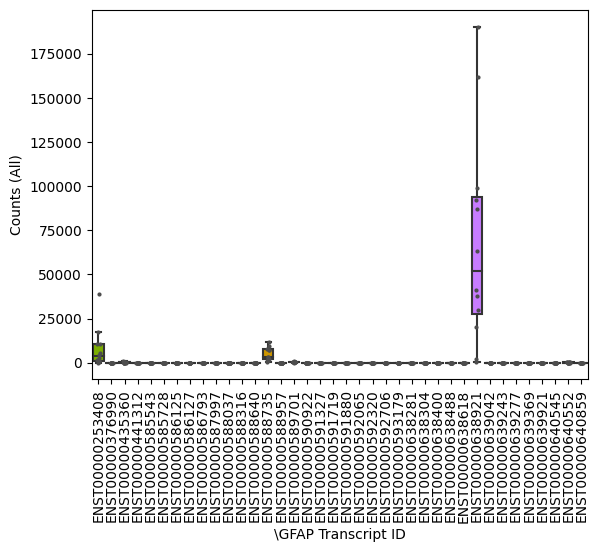

In [13]:
ax = sns.boxplot(data=df_counts_long, y="value", x="transcript_id",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=df_counts_long, y="value", x="transcript_id",
             color="#4d4d4d", size=3)

plt.xlabel("\GFAP Transcript ID")
plt.ylabel("Counts (All)")
plt.xticks(rotation = 90)

plt.savefig('../../figures/cemetery/GFAP/GFAP_all_counts.png',  
            dpi=600, transparent=True, bbox_inches="tight")

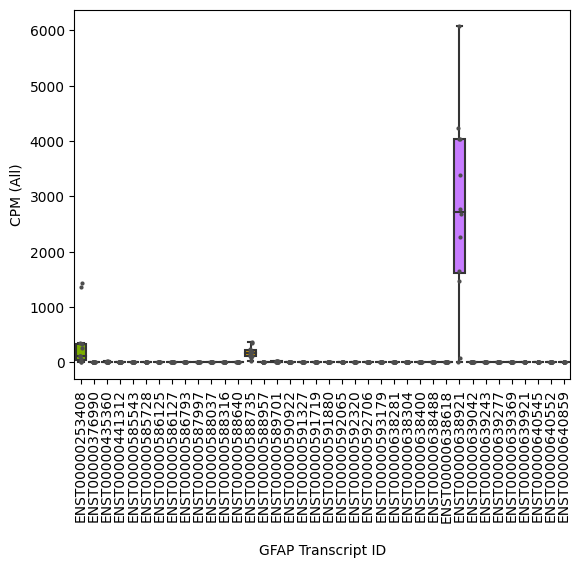

In [14]:
ax = sns.boxplot(data=df_cpm_long, y="value", x="transcript_id",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=df_cpm_long, y="value", x="transcript_id",
             color="#4d4d4d", size=3)

plt.xlabel("\nGFAP Transcript ID")
plt.ylabel("CPM (All)")
plt.xticks(rotation = 90)

plt.savefig('../../figures/cemetery/GFAP/GFAP_all_CPM.png',  
            dpi=600, transparent=True, bbox_inches="tight")

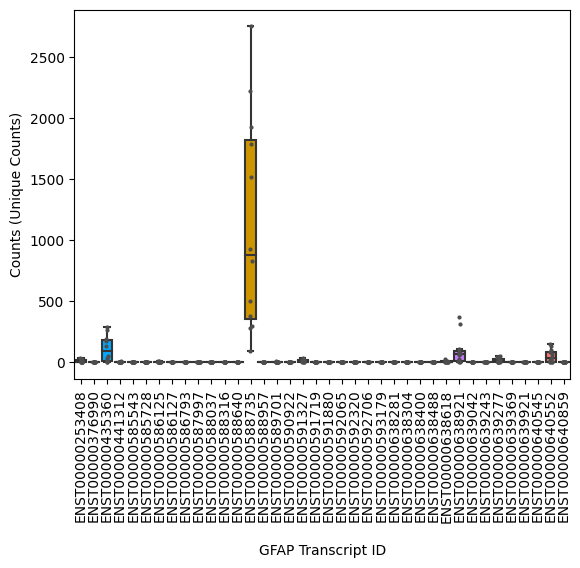

In [15]:
ax = sns.boxplot(data=df_unique_counts_long, y="value", x="transcript_id",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=df_unique_counts_long, y="value", x="transcript_id",
             color="#4d4d4d", size=3)

plt.xlabel("\nGFAP Transcript ID")
plt.ylabel("Counts (Unique Counts)")
plt.xticks(rotation = 90)

plt.savefig('../../figures/cemetery/GFAP/GFAP_unique_counts.png',  
            dpi=600, transparent=True, bbox_inches="tight")

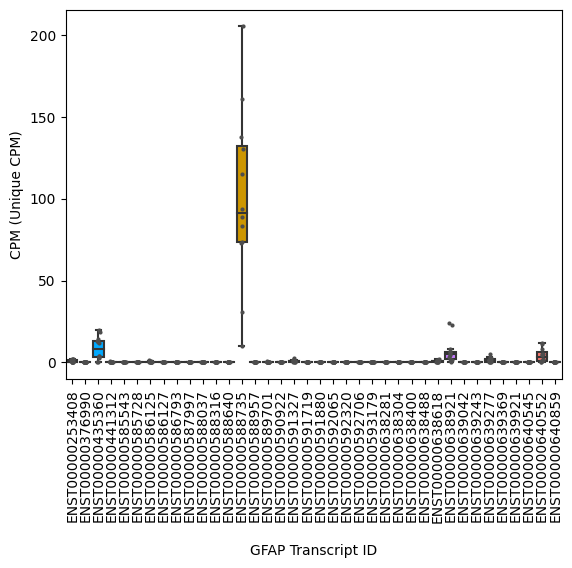

In [16]:
ax = sns.boxplot(data=df_unique_cpm_long, y="value", x="transcript_id",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=df_unique_cpm_long, y="value", x="transcript_id",
             color="#4d4d4d", size=3)

plt.xlabel("\nGFAP Transcript ID")
plt.ylabel("CPM (Unique CPM)")
plt.xticks(rotation = 90)

plt.savefig('../../figures/cemetery/GFAP/GFAP_unique_CPM.png',  
            dpi=600, transparent=True, bbox_inches="tight")

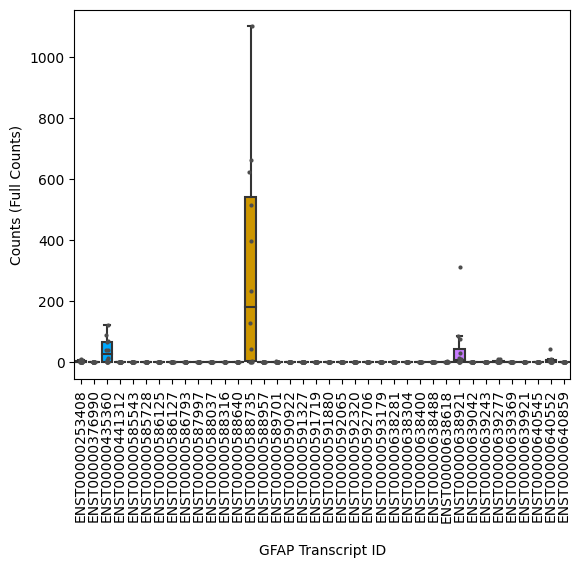

In [17]:
ax = sns.boxplot(data=df_full_counts_long, y="value", x="transcript_id",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=df_full_counts_long, y="value", x="transcript_id",
             color="#4d4d4d", size=3)

plt.xlabel("\nGFAP Transcript ID")
plt.ylabel("Counts (Full Counts)")
plt.xticks(rotation = 90)

plt.savefig('../../figures/cemetery/GFAP/GFAP_full_counts.png',  
            dpi=600, transparent=True, bbox_inches="tight")

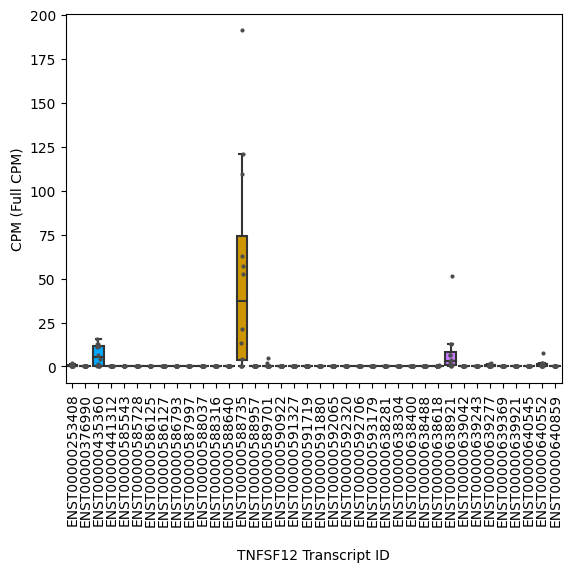

In [18]:
ax = sns.boxplot(data=df_full_cpm_long, y="value", x="transcript_id",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=df_full_cpm_long, y="value", x="transcript_id",
             color="#4d4d4d", size=3)

plt.xlabel("\nGFAP Transcript ID")
plt.ylabel("CPM (Full CPM)")
plt.xticks(rotation = 90)

plt.savefig('../../figures/cemetery/GFAP/GFAP_full_CPM.png',  
            dpi=600, transparent=True, bbox_inches="tight")